In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Space Mission Data Visualization



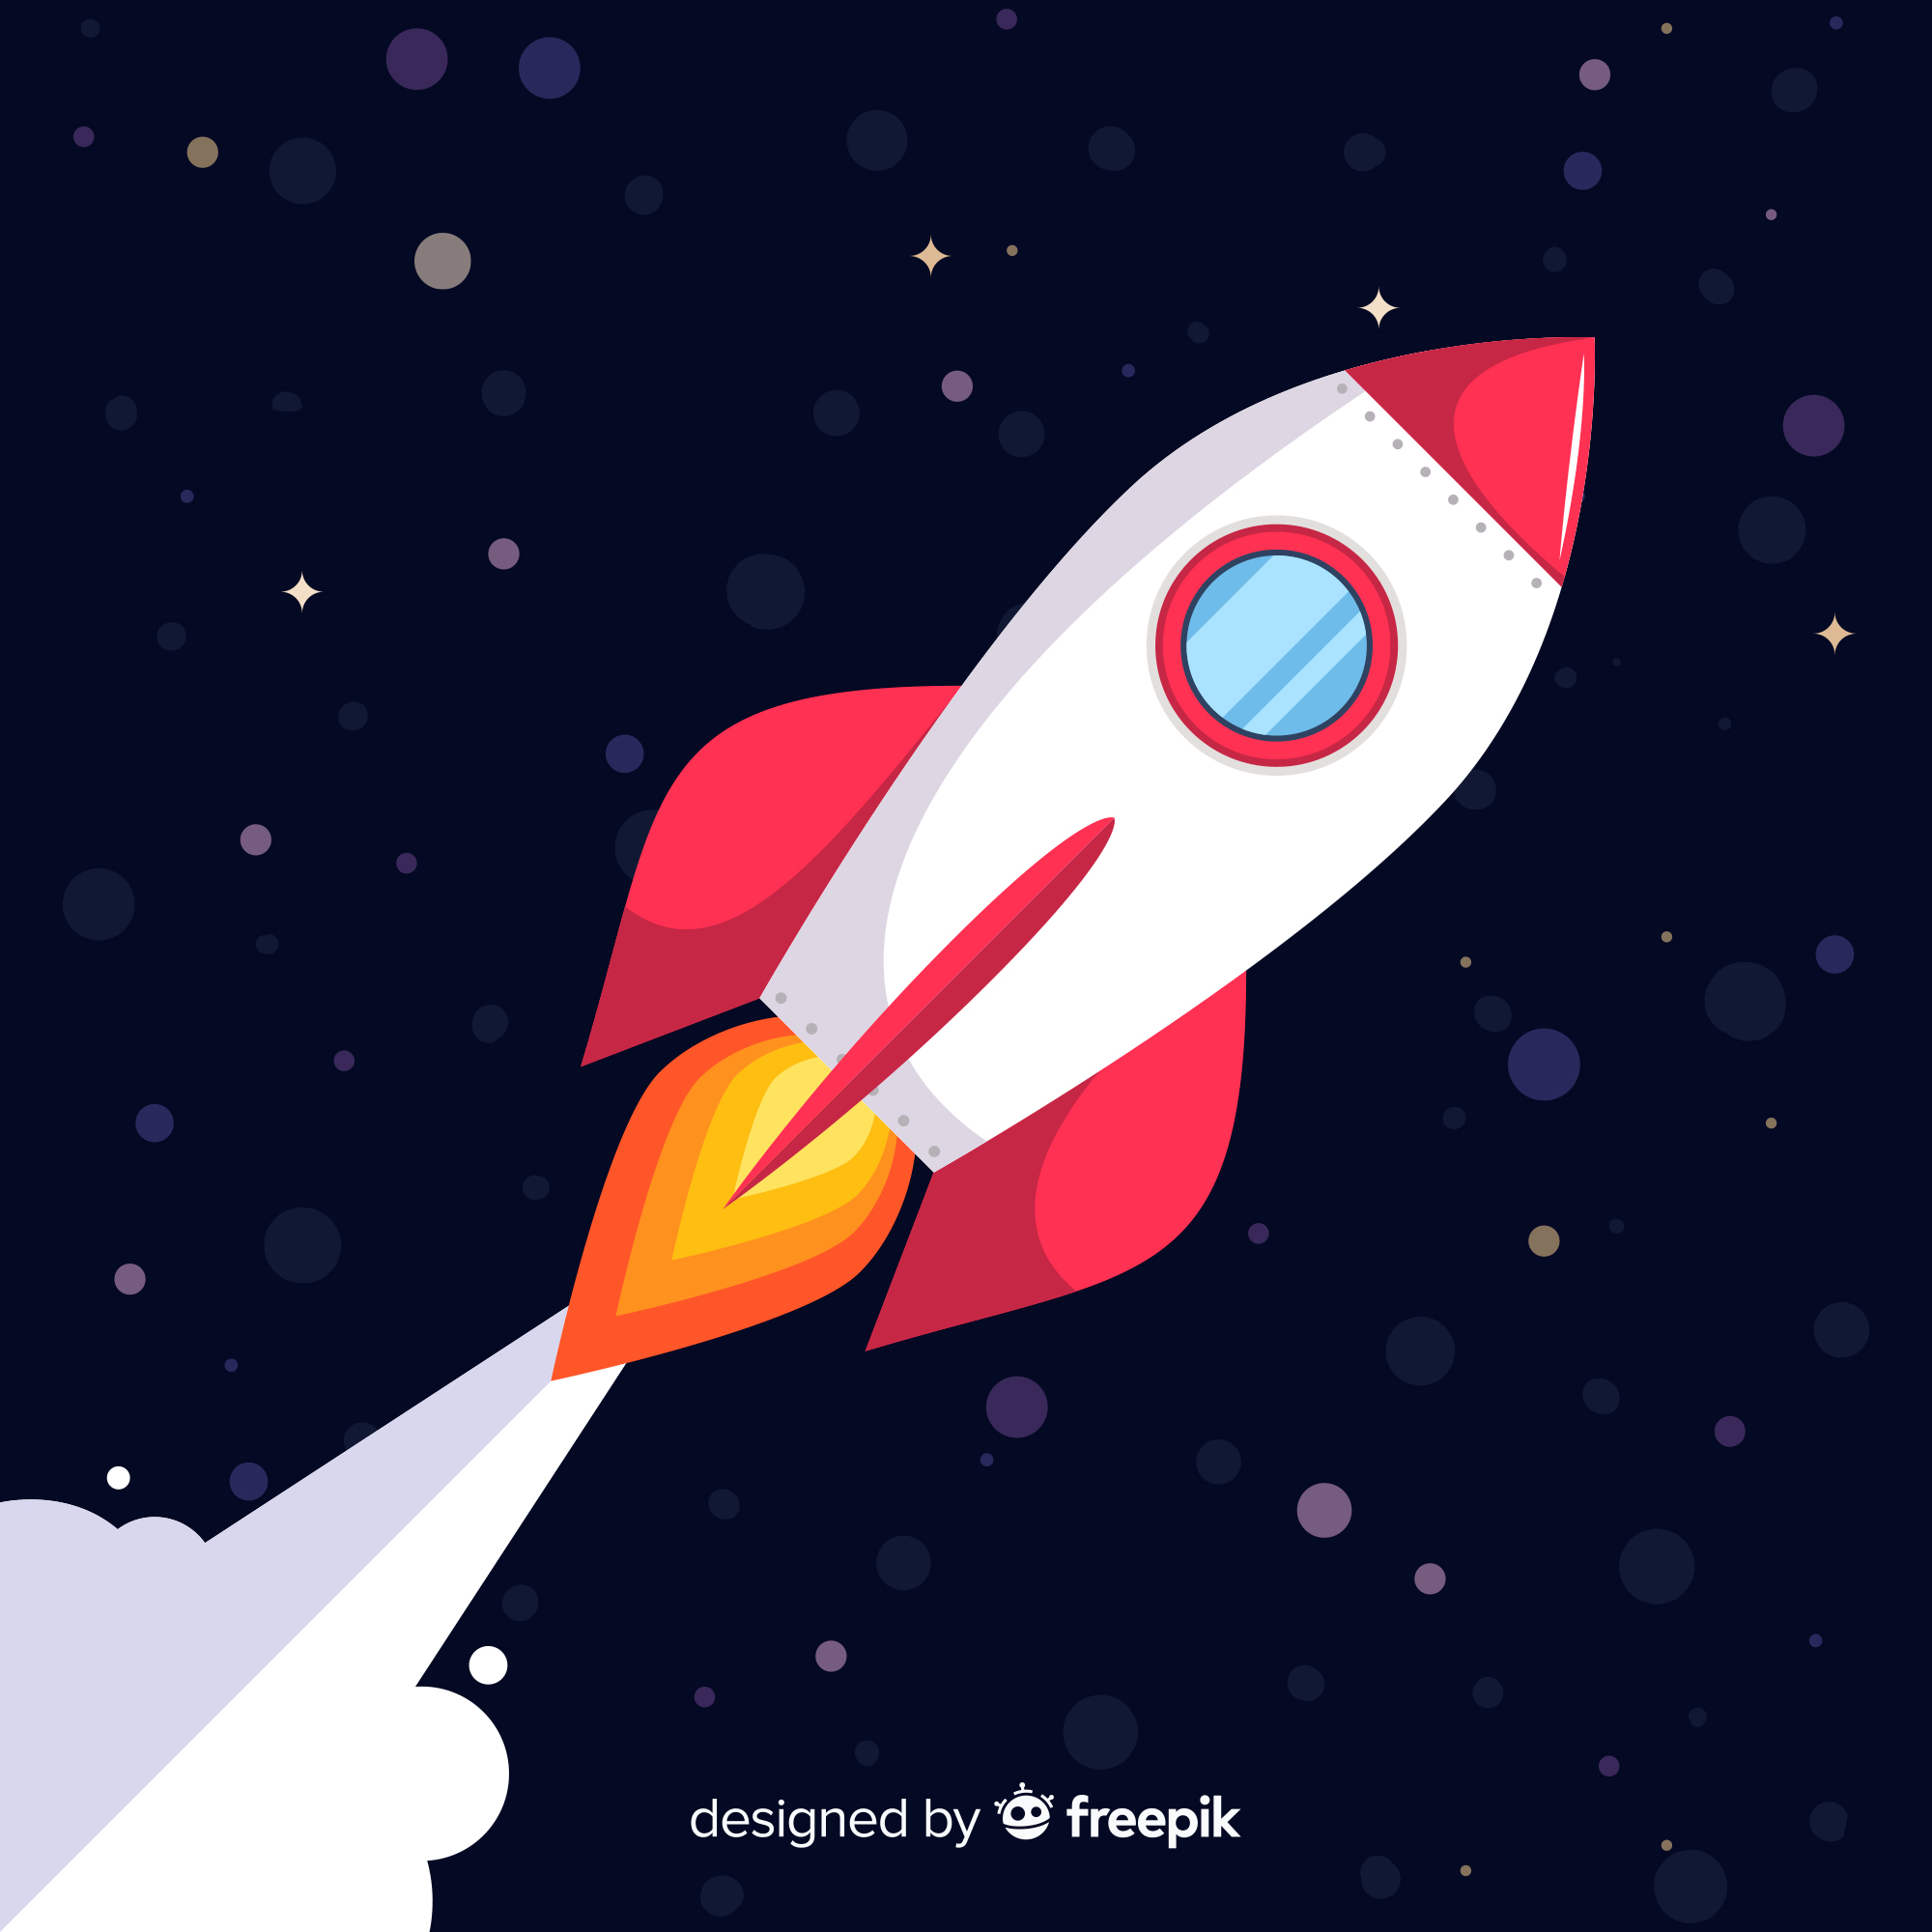

## Import library

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

In [ ]:
df = pd.read_csv('/kaggle/input/all-space-missions-from-1957/Space_Corrected.csv')
df.sample(7)

In [ ]:
df.columns

In [ ]:
df.isnull().sum() 

In [ ]:
df.dtypes

## Feature Engineering & Data Cleaning

In [ ]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df.rename(columns={' Rocket' : 'Rocket'}, inplace=True)


df['Datum'] = pd.to_datetime(df['Datum'].values)
df['Datum'] = df['Datum'].apply(lambda x : x.replace(tzinfo=None))
df['Datum'] = pd.DatetimeIndex(df['Datum'], freq=None)

df['Country'] = df.Location.apply(lambda x : x.split()[-1])
df.Country = df.Country.replace({
    'Zealand' : 'New Zealand', 
    'Site' : 'Iran', 
    'Sea' : 'Rest of World', 
    'Sandia' : 'USA',
    'Barents Sea' : 'Russia', 
    'Grand Canaria' : 'USA',
    'Ocean' : 'Multinational'
})


df.at[133, 'Country'] = 'China'

df['Rocket Name'] = df.Detail.apply(lambda x : x.split(' |')[0])


# Visualization
## 1. Space Mission from 1957 - 2020 Overview

In [ ]:
data1 = df.groupby('Country')['Status Mission'].count().sort_values(ascending=False)
row = data1[data1.values <= 14].sum()
data1 = data1[data1 > 14]
data1 = data1.combine(pd.Series({'Rest of World' : row}), max, fill_value=0)

data2 = df.groupby('Status Mission')['Detail'].count()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(
    labels=data1.index,
    values=data1.values,
    textinfo='label+percent',
    name='Space Launch'

),1,1)

fig.add_trace(go.Pie(
    labels=data2.index,
    values=data2.values,
    textinfo='label+percent',
    name='Mission Status'

),1,2)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text='Space Launch Overview',
    title_x = 0.5,
    template='ggplot2'
)

fig.show()

## 2. Space Mission Sunburst Chart

In [ ]:
data = df.groupby(['Country', 'Company Name'])['Status Mission'].count().reset_index()
data.rename(columns={"Status Mission" : 'Number of Missions'}, inplace=True)
fig = px.sunburst(data, path=['Country', 'Company Name'], values='Number of Missions')

fig.update_layout(
    title_text='Number of Space Mission Sunburst Chart',
    title_x = 0.5,
    template='ggplot2'

)
fig.show()


## 3. Space Mission Time Series (1957 - 2020)

In [ ]:
data = df.groupby(df.Datum.dt.year)['Status Mission'].count()
fig = go.Figure()

data2 = df[df['Status Mission'] == 'Failure']
data2 = data2.groupby(df.Datum.dt.year)['Status Mission'].count()

data3 = df[df['Status Mission'] == 'Success']
data3 = data3.groupby(df.Datum.dt.year)['Status Mission'].count()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data.values,
    showlegend=True,
    name='Space Mission',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=data2.index, 
    y=data2.values,
    showlegend=True,
    name='Failure Space Mission',
))

fig.add_trace(go.Scatter(
    x=data3.index, 
    y=data3.values,
    showlegend=True,
    name='Success of Space Mission',
))

fig.add_annotation(

    x=1975,
    y=120,
    ax=70,
    text="Space Race End 1975",
    showarrow=True,
)


fig.update_layout(
    title_text = 'Space Mission Time Series',
    shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1975, x1= 1975,
    )],
    template='plotly_dark',
    xaxis_title='Year',
    yaxis_title='Number of Space Mission'
)



## 4. Number of Space Mission by top 5 Country

In [ ]:
data = df.groupby(['Country'])['Status Mission'].count().sort_values(ascending=False)
top10 = data.iloc[:5]

data = df[df['Country'].isin(top10.index)] 
data = data.groupby([data.Datum.dt.year, data['Country']])['Status Mission'].count().reset_index()
fig = px.line(x=data.Datum, y=data['Status Mission'], color=data['Country'])


fig.add_annotation(

    x=1975,
    y=100,
    ax=70,
    text="Space Race End 1975",
    showarrow=True,
)
fig.update_layout(
    title_text="Number of Space Mission by top 5 Country",
    xaxis_title="Year",
    yaxis_title="Number of Space Mission",
    legend_title="Country",
    title_x=0.5,
    shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1975, x1= 1975,
    )],
    template='plotly_dark'

)

fig.show()


## 5. Number of Space Mission by Space Company with atleast 100 missions

In [ ]:
data = df.groupby(['Company Name'])['Status Mission'].count().sort_values(ascending=False)
top10 = data[data.values >= 100]

data = df[df['Company Name'].isin(top10.index)] 
data = data.groupby([data.Datum.dt.year, data['Company Name']])['Status Mission'].count().reset_index()

fig = px.line(x=data.Datum, y=data['Status Mission'], color=data['Company Name'])


fig.add_annotation(

    x=1975,
    y=100,
    ax=70,
    text="Space Race End 1975",
    showarrow=True,
)
fig.update_layout(
    title_text="Number of Space Mission by Space Company with atleast 100 missions",
    xaxis_title="Year",
    yaxis_title="Number of Space Mission",
    legend_title="Company Name",
    title_x=0.5,
    shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1975, x1= 1975,
    )],
    template='plotly_dark'

)

fig.show()

## 6. Number of Launch per month (all time)

In [ ]:
ldict = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']


data = df.groupby([df.Datum.dt.month, df['Status Mission']])['Detail'].count().reset_index()

data.Datum = data.Datum.replace({
    1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 
    6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'
})


fig =  px.bar(data, x=data.Datum, y=data.Detail, color=data['Status Mission'], text='Detail')

fig.update_layout(
    title_text="Number of Launch per month (all time)",
    title_x = 0.5,
    xaxis_title="Months",
    yaxis_title="Number of Mission",
    template='plotly_dark'
)
fig.show()

## 7. Ratio between Number of active rockets and retired

In [ ]:
data = df.groupby('Status Rocket')['Status Mission'].count()

fig = px.bar(df, x=data.index, y=data.values, template='plotly_dark')

fig.update_layout(
    title_text = 'Number of active rockets and retired',
    xaxis_title='Status',
    yaxis_title='Number of rockets',
    title_x = 0.5
    
)
fig.show()

## 8. Top 10 Rockets with most mission

In [ ]:
data = df.groupby('Rocket Name')['Detail'].count().sort_values(ascending=False).iloc[:10].sort_values(ascending=True)

fig = px.bar(data, y=data.index, x=data.values, template='plotly_dark')
fig.update_layout(
    title_text='Top 10 Rocket with most mission',
    title_x=0.5, 
    xaxis_title='Number of mission'
    
)
fig.show()